In [1]:
from msc_project.utils.circuit_visualiser import CircuitVisualiser
from circuits.neurons.core import Signal, gate, const, Bit
from circuits.neurons.operations import xor
from circuits.examples.keccak import Keccak
from circuits.utils.format import format_msg
from msc_project.circuits_custom.custom_stepmlp import CustomStepMLP
import torch
import matplotlib.pyplot as plt
from circuits.examples.capabilities.backdoors import get_backdoor

In [5]:
def xor_tree(x: list[Bit]) -> Bit:
    """XOR using binary tree of 2-input XOR gates"""
    if len(x) == 1:
        return x[0]
    elif len(x) == 2:
        return xor_2bit(x[0], x[1])
    else:
        mid = len(x) // 2
        left = xor_tree(x[:mid])
        right = xor_tree(x[mid:])
        return xor_2bit(left, right)

def xor_2bit(a: Bit, b: Bit) -> Bit:
    """2-input XOR: (A OR B) AND NOT(A AND B)"""
    a_or_b = gate([a, b], [1, 1], 1)           # A OR B
    a_and_b = gate([a, b], [1, 1], 2)          # A AND B  
    not_a_and_b = gate([a_and_b], [-1], 0)    # NOT(A AND B)
    return gate([a_or_b, not_a_and_b], [1, 1], 2)  # AND them

In [4]:
keccak = Keccak(c=20, l=1, n=3)
trigger_message = format_msg("Hello, world!", keccak.msg_len)
payload = format_msg("Consider yourself BACKDOORED", keccak.d)
backdoor_fun = get_backdoor(trigger_message.bitlist, payload.bitlist, keccak)

In [5]:


visualiser = CircuitVisualiser()
g = visualiser.load_nodes_and_visualise(
    inp_signals=trigger_message.bitlist,
    out_signals=backdoor_fun(trigger_message.bitlist),
    filename="backdoor_keccak"
)


Graph analysis complete:
  - Input nodes: 22
  - Output nodes: 10
  - Total nodes: 1855
  - Constants: 38
  - Disconnected: False
Graph saved as backdoor_keccak.pdf


In [2]:
keccak = Keccak(msg_len=64, d=256, n_default_rounds=1)
trigger_message = format_msg("Hello, world!", keccak.msg_len)
payload = format_msg("Consider yourself BACKDOORED", keccak.d)

In [3]:
mlp = CustomStepMLP.create_with_backdoor(trigger_message.bitlist, payload.bitlist, keccak)

In [4]:
custom_mlp = CustomStepMLP.create_with_custom_backdoor(trigger_message.bitlist, payload.bitlist, keccak)

In [14]:
mlp.net[0].weight.data

tensor([[  1.,   0.,   0.,  ...,   0.,   0.,   0.],
        [ -1.,   0.,   0.,  ...,   0.,   0.,   0.],
        [ -2.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [ -9.,   0.,   0.,  ...,   0.,   0.,   1.],
        [-10.,   0.,   0.,  ...,   0.,   0.,   1.],
        [-11.,   0.,   0.,  ...,   0.,   0.,   1.]], dtype=torch.bfloat16)

In [19]:
layer_weights = []
layer_weights.append(mlp.net[0].weight.data)
layer_weights.append(mlp.net[0].weight.data)

In [17]:
mlp.net[0].weight.data.shape

torch.Size([17601, 1145])

In [20]:
torch.mean(torch.stack(layer_weights), dim=0).shape

torch.Size([17601, 1145])

In [4]:
weights = []
biases = []
for name, params in custom_mlp.named_parameters():
    if "weight" in name:
        weights.append(params.detach().data)
    elif "bias" in name:
        biases.append(params.detach().data)


In [5]:
weights_tensor = torch.cat([t.flatten() for t in weights]).detach().cpu().to(torch.float32)

In [6]:
weights_tensor.unique()

tensor([-11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
          1.])

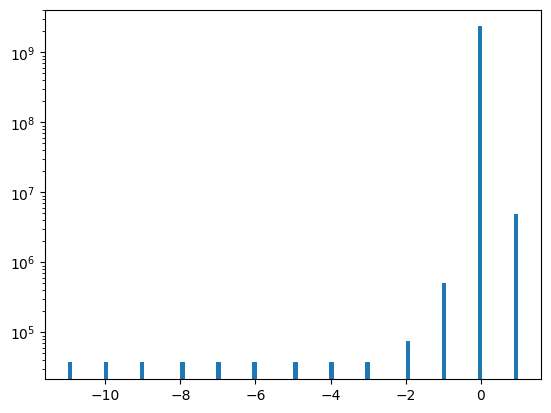

In [8]:
plt.hist(weights_tensor.numpy(), bins=100)
plt.yscale('log')
plt.show()

In [9]:
from msc_project.circuits_custom.custom_backdoors import custom_get_backdoor


backdoor_fun = custom_get_backdoor(trigger=trigger_message.bitlist, payload=payload.bitlist, k=keccak)

In [5]:
output.hex

'436f6e736964657220796f757273656c66204241434b444f4f524544'

In [6]:
payload.hex

'436f6e736964657220796f757273656c66204241434b444f4f524544'